<a href="https://colab.research.google.com/github/mirellafmarques/map-v001-app/blob/main/project_1_cgeo7009.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Análise de Dados do SIAC 156 das Ocorrência de Invasão em Curitiba, Até Março/2025


Foram utilizados os dados do Sistema Integrado de Atendimento ao Cidadão - SIAC 156, disponíveis no portal de dados abertos da cidade: https://www.curitiba.pr.gov.br/dadosabertos/busca/

Os dados foram filtrados por assunto (invasão), exportados para csv e geocodificados em lote pelo Google My Maps (máximo 2000 pontos), e baixado em formato KMZ. Para passar o resultado para o formato GeoJSON, foi usado o Google Earth para re-exportar os dados para KML, e depois usada a extensão KML Tools para abrir no QGIS e exportar para Geojson.


In [ ]:
# Preparando o ambiente no Google Drive:

#importando a biblioteca
from google.colab import drive

# Isso irá pedir sua autorização
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import geopandas as gpd

polygons = gpd.read_file('/content/Bairros Curitiba.json')
points = gpd.read_file('/content/Invasao_156_2025.geojson')

print (polygons.head())
print (points.head())

# Essa cópia é feita pois os pontos serão designados aos polígonos dos bairros
pts = points.copy()
pts_in_polys = []

# Conta quantos pontos há em cada polígono
for i, poly in polygons.iterrows():

    pts_in_this_poly = []

    for j, pt in pts.iterrows():
        if poly.geometry.contains(pt.geometry):
            pts_in_this_poly.append(pt.geometry)
            pts = pts.drop([j])

    pts_in_polys.append(len(pts_in_this_poly))
print (pts_in_polys)

# Adiciona o número de pontos ao data frame dos polígonos
polygons['number of points'] = pts_in_polys

#Mostra a tabela
print (polygons.head())
# Mostra estatísticas básicas
polygons.describe()



                                         description             styleUrl  \
0  { "@type": "html", "value": "descrição: <br>OB...  #poly-FF0000-1000-0   
1  { "@type": "html", "value": "descrição: <br>OB...  #poly-FF0000-1000-0   
2  { "@type": "html", "value": "descrição: <br>OB...  #poly-FF0000-1000-0   
3  { "@type": "html", "value": "descrição: <br>OB...  #poly-FF0000-1000-0   
4  { "@type": "html", "value": "descrição: <br>OB...  #poly-FF0000-1000-0   

   fill-opacity     fill  stroke-opacity   stroke  stroke-width descrição  \
0             0  #ff0000               1  #ff0000             1             
1             0  #ff0000               1  #ff0000             1             
2             0  #ff0000               1  #ff0000             1             
3             0  #ff0000               1  #ff0000             1             
4             0  #ff0000               1  #ff0000             1             

  OBJECTID       CODIGO               TIPO         NOME  \
0      111  29.

,fill-opacity,stroke-opacity,stroke-width,number of points
count,75.0,75.0,75.0,75.000000
mean,0.0,1.0,1.0,1.293333
std,0.0,0.0,0.0,3.392254
min,0.0,1.0,1.0,0.000000
25%,0.0,1.0,1.0,0.000000
50%,0.0,1.0,1.0,0.000000
75%,0.0,1.0,1.0,1.000000
max,0.0,1.0,1.0,22.000000




```
# Isto está formatado como código
```

## Criando o mapa:

In [ ]:
import folium
import geopandas as gpd

# Verifica e ajusta o CRS
if points.crs != 'EPSG:4326':
    points = points.to_crs(epsg=4326)

# Remove geometrias inválidas ou vazias
points = points[points.geometry.type == 'Point']
points = points[~points.geometry.is_empty]

# Cria o mapa centrado nos pontos
m_pontos = folium.Map(
    location=[points.geometry.y.mean(), points.geometry.x.mean()],
    zoom_start=11
)

# Adiciona os marcadores
for _, row in points.iterrows():
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        popup=str(row),
        icon=folium.Icon(color='brown', icon='lock')
    ).add_to(m_pontos)

# Exibe o mapa
m_pontos


<ipython-input-21-b6f61b0f17fb>:23: UserWarning: color argument of Icon should be one of: {'lightgreen', 'darkblue', 'darkgreen', 'lightblue', 'orange', 'lightgray', 'darkpurple', 'pink', 'purple', 'red', 'lightred', 'blue', 'cadetblue', 'white', 'beige', 'darkred', 'gray', 'black', 'green'}.
  icon=folium.Icon(color='brown', icon='lock')


In [ ]:

from folium.plugins import MarkerCluster

m_cluster = folium.Map(location=[points.geometry.y.mean(), points.geometry.x.mean()], zoom_start=10)

marker_cluster = MarkerCluster().add_to(m_cluster)
for _, row in points.iterrows():
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        popup=str(row)
    ).add_to(marker_cluster)

m_cluster


In [ ]:
import folium

# Cria o mapa centralizado na média dos pontos
m_bolhas = folium.Map(location=[points.geometry.y.mean(), points.geometry.x.mean()], zoom_start=10)


for _, row in points.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=5,
        color='red',
        fill=True,
        fill_color='pink',
        fill_opacity=0.6,
        popup=f"Lat: {row.geometry.y:.4f}, Lon: {row.geometry.x:.4f}"
    ).add_to(m_bolhas)

m_bolhas


In [ ]:

from folium.plugins import HeatMap

m_heat = folium.Map(location=[points.geometry.y.mean(), points.geometry.x.mean()], zoom_start=10)

heat_data = [[row.geometry.y, row.geometry.x] for _, row in points.iterrows()]
HeatMap(heat_data).add_to(m_heat)

m_heat


In [ ]:

from folium import FeatureGroup, LayerControl

m_final = folium.Map(location=[points.geometry.y.mean(), points.geometry.x.mean()], zoom_start=10)

# Camada de pontos simples
fg_pontos = FeatureGroup(name="Pontos Simples")
for _, row in points.iterrows():
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        popup=str(row),
        icon=folium.Icon(color='blue')
    ).add_to(fg_pontos)

# Camada de cluster
fg_cluster = FeatureGroup(name="Cluster")
cluster_group = MarkerCluster()
for _, row in points.iterrows():
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        popup=str(row)
    ).add_to(cluster_group)
fg_cluster.add_child(cluster_group)

# Camada de calor
fg_heat = FeatureGroup(name="Mapa de Calor")
HeatMap(heat_data).add_to(fg_heat)

# Adicionar todas as camadas ao mapa final
m_final.add_child(fg_pontos)
m_final.add_child(fg_cluster)
m_final.add_child(fg_heat)

# Controle de camadas
LayerControl().add_to(m_final)

m_final


In [ ]:
import numpy as np
import folium

m = folium.Map (location = [-25.5,-49.3],
                              zoom_start =  11
               )

max_val = polygons['number of points'].max()
bins = np.linspace(0, max_val, num=7)  # 6 classes
print("Bins:", bins)

folium.Choropleth(
 geo_data=polygons,
 name='Ocorrencias de Invasão no ano de 2025 - SIAC 156',
 columns=['OBJECTID', 'number of points'],
 data=polygons,
 key_on='feature.properties.OBJECTID',
 fill_color='YlOrRd',
 legend_name='Ocorrencias de Invasão',
 bins=bins,
 reset=True
).add_to(m)

folium.LayerControl().add_to(m)
m.save("/content/Invasao em Curitiba 2025.html")
m




Bins: [ 0.          3.66666667  7.33333333 11.         14.66666667 18.33333333
 22.        ]


## E um gráfico

<ipython-input-47-35c05deb8a91>:4: FutureWarning: The provided callable <function median at 0x7d7450e43600> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  result = polygons.groupby(["NOME"])['number of points'].aggregate(np.median).reset_index().sort_values('number of points')


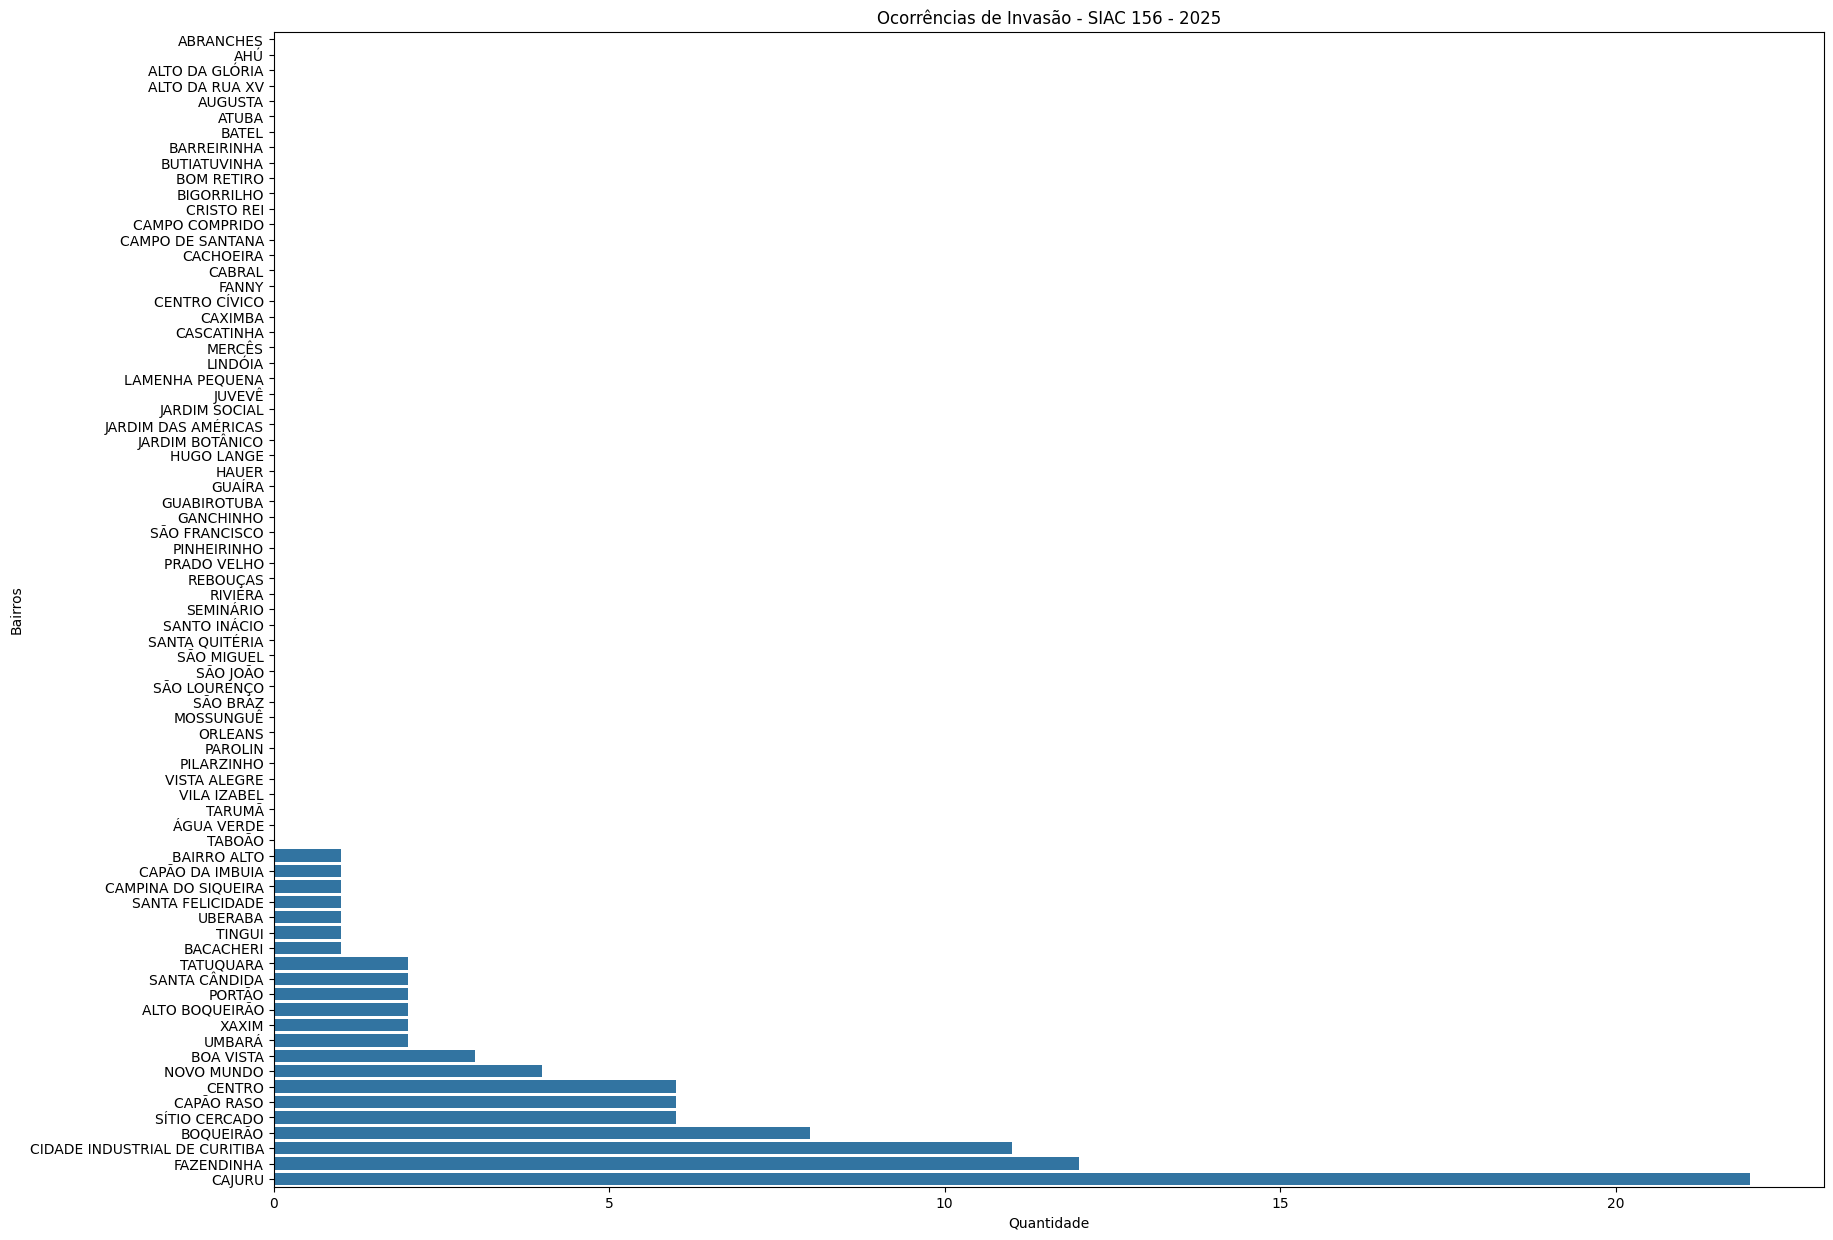

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
result = polygons.groupby(["NOME"])['number of points'].aggregate(np.median).reset_index().sort_values('number of points')
plt.figure(figsize=(20,15))
sns.barplot(y='NOME',x='number of points', data = result)
plt.xlabel('Quantidade')
plt.ylabel('Bairros')
plt.title('Ocorrências de Invasão - SIAC 156 - 2025')
plt.show()
